# Capstone Project - The Battle of the Neighborhoods
> <span style="color:brown;font-family:Papyrus; font-size:1em"> **SETTING UP A NEW AFRICAN RESTUARANT IN A TORONTO NEIGHBORHOOD** </span>.
> ### *Samuel Onekutu*
><img src="nigerianresurant.jpg"
     style="float: left; margin-right: 10px;" />
><img src="UnionStationToron.jpg"
     style="float: right; margin-right: 5px;" />

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

A successful Restaurant business board  from Nigeria_Africa is looking to break into the market space around The Canadian capital Toronto , given that only very few African restaurant exist in the area, being foreign investor;  they want to know what area is will have less competition and  importantly a viable market 

They have approached a data scientist for data back recommendations before taking the leap into the unknown;

## Data <a name= 'data'>

Data  sourced from **Wikipedia web page** using webscrapping and venue information from **Four Square API** and **lastly Geodata file**, all this was combined/cleansed into a location data for the Toronto Area.
to get : Neighborhood arround toronto, Venues in each neighborhood, total Restuarant per hood and total venues per hood half akilometer from neighborhood centers 

This location Data will be used to create different models, after determining  number of restaurants per neighborhood as the dependent  variable, this is excluded and the rest of the data it clustered and compared against the dependent variable for correlation and tested again for best model that can accurately find viable neighborhoods with lest competition 
Some models to use include Linear Regression and Kmeans Clustering

#### *importing libraries*

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [3]:
from sklearn.cluster import KMeans
import folium # map rendering library


#### *data collection and preparation*

In [4]:
# COLLECTING DATA FOR TORONTO CITY AREA
# WEB SCRAPING

site= "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(site).text
soup = BeautifulSoup(page,"html5lib")
tables = soup.find_all("table")
type(tables)

bs4.element.ResultSet

In [5]:
df_hood= pd.DataFrame(columns=['Postal Code','Borough','Neighborhood'])
row1=tables[0].tbody.find_all('td')
for col in row1:
    if ("Not assigned") not in col.text:
        ab=col.text
        code= ab[1:4]
        hood=ab.split('(')[1][:-3]
        hood=hood.replace('/',', ')
        borough=ab.split('(')[0][4:]
        df_hood=df_hood.append({'Postal Code':code,'Borough':borough,'Neighborhood':hood}, ignore_index=True)
df_hood.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [6]:
# INSERTING THE LATIDUTED AND LONGITUDE
# FROM DOWNLOAD GEODATA FILE THEN MERGING TWO DATAFRAMES
geodata=pd.read_csv("Geospatial_Coordinates.csv")
df_hood =df_hood.join(geodata.set_index('Postal Code'),on='Postal Code')
df_hood.head()


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [7]:
df_hood.shape

(103, 5)

In [8]:
# GETTING OUT ONLY TORONTO AREA OUT
listed=pd.DataFrame(columns=['name'])
for borough in df_hood['Borough']:
    if'Toronto'in borough:
        listed=listed.append({'name':borough},ignore_index=True)
    else:
        None 
listed
toronto_area=listed.name.unique()
toronto_area
df_toronto=pd.DataFrame(columns=df_hood.columns)
df_toronto=df_hood[df_hood.Borough.isin(toronto_area)].reset_index().drop(["index"],axis=1)
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


#### *getting more data from Four Square* 

In [9]:
CLIENT_ID = 'F5KSGNKOZRAOFG4ZXMO1ZJPVN1IGALY0PR5HN0ZOYV345LQH' # your Foursquare ID
CLIENT_SECRET = 'SORNULU0JV3EQL5V4BRVZMNPKKLHYNPSCZYAN4N54H42PKQJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # i tried 150 for better segmentation though cap was set back to 100


In [10]:
 url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            43.654260, 
            -79.360636, 
            500, 
            LIMIT)
results = requests.get(url).json()["response"]['groups'][0]['items']
#results

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
toronto_venues=getNearbyVenues(df_toronto['Neighborhood'],df_toronto['Latitude'],df_toronto['Longitude'])
toronto_venues.shape

(1597, 7)

In [13]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park , Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park , Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park , Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park , Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park , Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [14]:
cat=toronto_venues['Venue Category'].unique()
all_resturants=[]
for v in cat:
    if "Restaurant" in v:
        all_resturants.append(v)
all_resturants.sort()
print(all_resturants)

['American Restaurant', 'Asian Restaurant', 'Belgian Restaurant', 'Brazilian Restaurant', 'Cajun / Creole Restaurant', 'Caribbean Restaurant', 'Chinese Restaurant', 'Colombian Restaurant', 'Comfort Food Restaurant', 'Cuban Restaurant', 'Doner Restaurant', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Ethiopian Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'French Restaurant', 'German Restaurant', 'Gluten-free Restaurant', 'Greek Restaurant', 'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Latin American Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Modern European Restaurant', 'Molecular Gastronomy Restaurant', 'Moroccan Restaurant', 'New American Restaurant', 'Portuguese Restaurant', 'Ramen Restaurant', 'Restaurant', 'Seafood Restaurant', 'Sri Lankan Restaurant', 'Sushi Restaurant', 'Taiwanese Restaurant', 'Thai Restaurant', 'Theme Restaurant', 'Tibetan R

In [15]:
venue_hood_count= toronto_venues.groupby("Neighborhood").count().reset_index()
venue_hood_count.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,59,59,59,59,59,59
1,"Brockton , Parkdale Village , Exhibition Place",23,23,23,23,23,23
2,"CN Tower , King and Spadina , Railway Lands ...",16,16,16,16,16,16
3,Central Bay Street,63,63,63,63,63,63
4,Christie,16,16,16,16,16,16


#### *creating a table of neighborhood by no. resturant count*

In [16]:
restaurant_count=pd.DataFrame(columns=['Neighborhood','Restaurant_count'])
#resturant_count

for hood,ven in zip (toronto_venues['Neighborhood'],toronto_venues['Venue Category']):
    if ven in all_resturants:
        restaurant_count=restaurant_count.append({'Neighborhood':hood,'Restaurant_count':ven}, ignore_index=True)
restaurant_count=restaurant_count.groupby("Neighborhood").count().sort_values("Restaurant_count",ascending=False)
restaurant_count.reset_index()

restaurant_count.head()


,Restaurant_count
Neighborhood,
"First Canadian Place , Underground city",31
"Commerce Court , Victoria Hotel",29
Church and Wellesley,26
"Toronto Dominion Centre , Design Exchange",25
"Richmond , Adelaide , King",25


In [20]:
pc=df_merged
pc['Restaurant_count'].replace(np.NaN,0,inplace=True)


### METHODOLOGY <a name= 'methodology'>

two major factors are put to play that is:
##### * *commercially viable neighborhoods*
##### * *area with least competition in restuarant* 

in this project with the data available and gathered by me,(four squared venue data) I intend use three models to determine the best location for a new african restuarant based on the two factor above
* first to run a *Regression Model* to determine a relationship or correlation between triving commercal hood and number of restuarants
* second cluster neighborhood together base on their venue setup similarities then
* to combine the effects of the first two results there by creation a cluster of neighborhoods with commercial activties and smilarity of venue

all this done excluding the **Dependent y** *variable we know to be number of restuarants per Hood*
so that we can evaluate our models accuracy testing how well it can predict our dependent variable: the number of restuarants

the best model is found and used to get results

### DATA ANALYSIS: <a name = analysis>
#### *1. Linear Regression: is there a correlation between no. venues and no. of restuarants. we will merge and plot to see*  

In [18]:
df_merged=venue_hood_count[['Neighborhood','Venue']]
df_merged=df_merged.join(restaurant_count,on='Neighborhood')
df_merged.head()


,Neighborhood,Venue,Restaurant_count
0,Berczy Park,59,11.0
1,"Brockton , Parkdale Village , Exhibition Place",23,2.0
2,"CN Tower , King and Spadina , Railway Lands ...",16,NaN
3,Central Bay Street,63,15.0
4,Christie,16,2.0


In [21]:
df_merged[["Venue","Restaurant_count"]].corr()

,Venue,Restaurant_count
Venue,1.000000,0.933148
Restaurant_count,0.933148,1.000000


<AxesSubplot:xlabel='Venue', ylabel='Restaurant_count'>

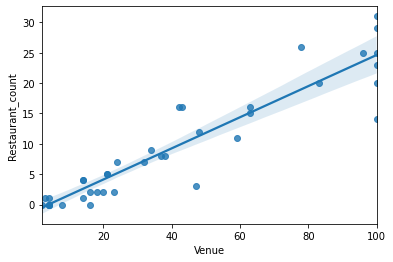

In [22]:
sns.regplot(x="Venue", y="Restaurant_count", data=df_merged)

 with Correlation at **0.91** we can say except for the few out layers that we on to something
 lets saves this result on go on to use  
 
 ***2.  CLUSTERING*** to further analysis trends between Neighborhood Smilarities and Number of Restuarants

  because restaurant y is our independant variable lets remove all 45 of it

In [23]:
toronto_xvenues=toronto_venues[toronto_venues['Venue Category'].isin (toronto_venues['Venue Category'].replace(all_resturants,False))]#xvenues for venues other than restuarants

In [24]:
## turning categorical into numerical
df_cat=pd.get_dummies(toronto_xvenues[['Venue Category']],prefix="", prefix_sep="")
## adding neighborhood name back
df_cat['Neighborhood'] = toronto_xvenues['Neighborhood']
list(df_cat.columns).index('Neighborhood')
fixed_columns = ([df_cat.columns[126]] + list(df_cat.columns[:126]) + list(df_cat.columns[127:]))
df_cat = df_cat[fixed_columns]
df_cat.head()

,Museum,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,...,Tanning Salon,Tea Room,Tennis Court,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



#### *creating data for neighborhood venue pattern let consolidate and normalize data*

In [25]:
df_hood_ratio=df_cat.groupby("Neighborhood").mean().reset_index()
df_hood_ratio.head()

,Neighborhood,Museum,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,...,Tanning Salon,Tea Room,Tennis Court,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Yoga Studio
0,Berczy Park,0.020833,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.047619
2,"CN Tower , King and Spadina , Railway Lands ...",0.000000,0.0,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,Central Bay Street,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,...,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.020833
4,Christie,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


#### *imploring Machine learning Clustering tool kmeans, lets label_ this hoods*

In [26]:
kclusters=6
df_hood_cluster=df_hood_ratio.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_hood_cluster)

# checking cluster labels generated for each row in the dataframe
len(kmeans.labels_)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 5, 0, 1,
       0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

 **at k=5 this results suggests that 33 neighborhoods out of 38 are similar this is too open and vauge**
#### *but at K=6 we get a slightly more diverse result*

In [27]:
# lets fit label_s in
df_hood_ratio.insert(0, 'Cluster Labels',kmeans.labels_)
df_hood_ratio.head()

,Cluster Labels,Neighborhood,Museum,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Tanning Salon,Tea Room,Tennis Court,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Yoga Studio
0,0,Berczy Park,0.020833,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.047619
2,0,"CN Tower , King and Spadina , Railway Lands ...",0.000000,0.0,0.0625,0.0625,0.0625,0.125,0.1875,0.125,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0,Central Bay Street,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.020833
4,0,Christie,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [31]:
def shorter(text):
    a=str(text)[:10]
    return a
xlabel=df_labeled['Neighborhood'].apply(shorter)
xlabel=tuple(xlabel.values)


#### lets insert our independent variable no. of resturant and check for any similar correlations 

Neighborhood by No. of restuarants and cluster label_


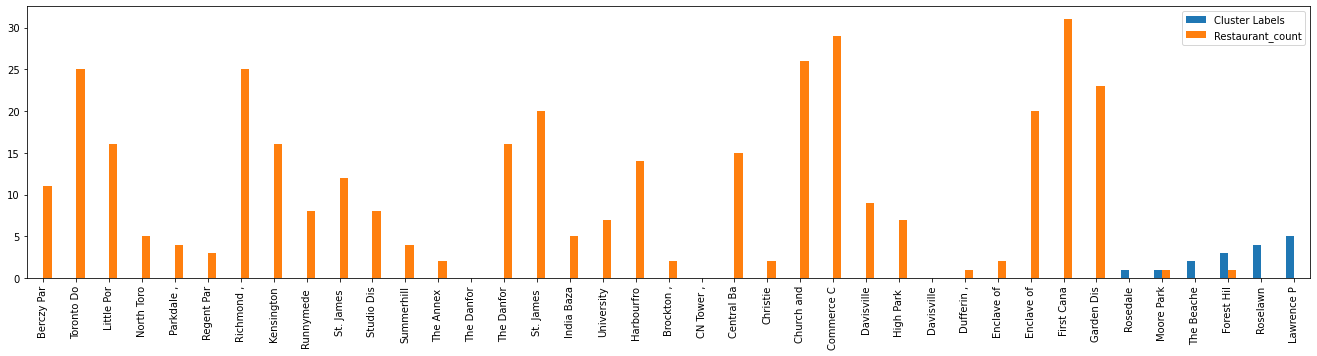

In [32]:
df_labeled=df_hood_ratio.join(restaurant_count,on='Neighborhood')
df_labeled= df_labeled[['Neighborhood','Cluster Labels','Restaurant_count']].sort_values('Cluster Labels').reset_index()
x=df_labeled.index
df_labeled[['Cluster Labels','Restaurant_count']].plot(kind='bar',figsize=(23,5))
plt.xticks(x,xlabel)
print("Neighborhood by No. of restuarants and cluster label_")

#### some trend is appearing, now what if we factor total number on venues like we found earlier to our clustering algorithm combine both neighborhood venue smilarity and number total number of venues...  

### COMBINED_CLUSTER:
### ultimately we can find that neigbhood out layer that need to have more restuarants to attain equilibrum too 

In [33]:
df_hood_rm=df_hood_ratio.join(df_merged[['Neighborhood','Venue']].set_index('Neighborhood'), on='Neighborhood')
df_hood_rm.head(1)

,Cluster Labels,Neighborhood,Museum,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Tea Room,Tennis Court,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Yoga Studio,Venue
0,0,Berczy Park,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59


In [34]:
kclusters=6
df_hood_cluster2=df_hood_rm.drop(['Neighborhood','Cluster Labels'], 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_hood_cluster2)

# checking cluster labels generated for each row in the dataframe
kmeans.labels_

array([5, 3, 3, 5, 3, 4, 1, 2, 0, 3, 3, 1, 1, 0, 1, 1, 3, 3, 5, 0, 2, 0,
       3, 3, 2, 1, 0, 0, 2, 4, 2, 2, 3, 3, 0, 0, 2, 1, 2])

In [35]:
df_hood_rm.insert(0, 'Cluster Labels2',kmeans.labels_)
df_hood_rm.head()

,Cluster Labels2,Cluster Labels,Neighborhood,Museum,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Tea Room,Tennis Court,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Yoga Studio,Venue
0,5,0,Berczy Park,0.020833,0.0,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,59
1,3,0,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.047619,23
2,3,0,"CN Tower , King and Spadina , Railway Lands ...",0.000000,0.0,0.0625,0.0625,0.0625,0.125,0.1875,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,16
3,5,0,Central Bay Street,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,...,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.020833,63
4,3,0,Christie,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,16


In [38]:
def shorter(text):
    a=str(text)[:10]
    return a
xlabel2=df_labeled2['Neighborhood'].apply(shorter)
xlabel2=tuple(xlabel2.values)

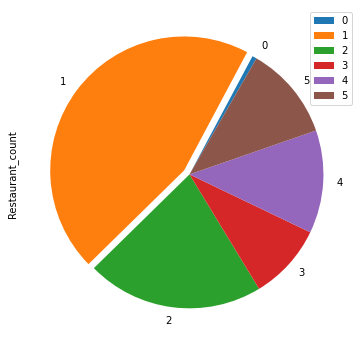

In [52]:
df_pie=df_labeled2[['Cluster Labels2','Restaurant_count']].groupby('Cluster Labels2').sum()
df_pie['Restaurant_count'].plot(kind='pie',figsize=(6,8),startangle=60,explode=[0,0.05,0,0,0,0],)
plt.legend(labels=df_pie.index)

### shows that cluster 1 stands out followed by cluster 0 as cluster with triving Resturant Business
## visualizing this result in another way, we can see the individual hoods in the cluster and resturant saturation

Neighborhood by No. of restuarants and 2nd cluster labeled cluster_1 is seen


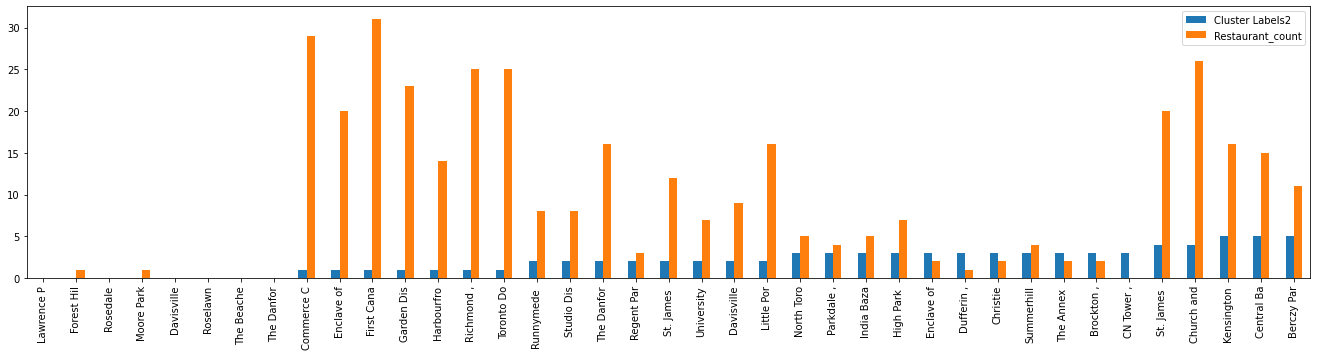

In [44]:
df_labeled2=df_hood_rm.join(restaurant_count,on='Neighborhood')
df_labeled2= df_labeled2[['Neighborhood','Cluster Labels2','Restaurant_count','Venue']].sort_values('Cluster Labels2').reset_index()
x=df_labeled2.index
df_labeled2[['Cluster Labels2','Restaurant_count']].plot(kind='bar',figsize=(23,5))
plt.xticks(x,xlabel2)
print("Neighborhood by No. of restuarants and 2nd cluster labeled cluster_1 is seen")

In [45]:
recommendatn=df_labeled2[['Neighborhood','Cluster Labels2','Restaurant_count',"Venue"]][df_labeled2['Cluster Labels2']==1].sort_values('Restaurant_count').reset_index()
recommendatn.head(3)

,index,Neighborhood,Cluster Labels2,Restaurant_count,Venue
0,12,"Harbourfront East , Union Station , Toronto ...",1,14.0,100
1,9,Enclave of M5E,1,20.0,100
2,11,"Garden District, Ryerson",1,23.0,100


## RESULT AND DISCUSSION <a name= "results">

### interpreting data we can see that Harbourfront East  and Enclave of M5E neighborhoods 
#### are the most promising because they are not yet saturated with a many restuarants yet and a have the atributes of all the places with teaming Restuarants
#### harbourFront having only 14 restuarants and over a 100 our venues means that is ranks top on our list of neighborhoods follow by the Enclaves and Garden District and after review of this areas we find that there are no african resturants. we pick Enclaves as the  second runner up because it has 2 restuarants less compared with Garden Districts


In [46]:
toronto_merged=df_toronto
toronto_merged=toronto_merged.join(df_hood_rm.set_index("Neighborhood"),on= "Neighborhood")
toronto_merged['Cluster Labels2']=toronto_merged['Cluster Labels2'].replace(np.NAN,0).astype(int)


In [47]:
latitude= toronto_merged['Latitude'].mean()
longitude= toronto_merged['Longitude'].mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

## Conclusion <a name= 'conclusion'>
    
    
in this project we set out to use location data to determine the most vaible location for an african Resuarant in a neighborhood commercial enough for patornage and with little as much competition arising from presence of other restuarant
using four square venue data along with some machine learning clustering algorthm we arrived at two promising neigborhoods Harbourfront East and Enclave of M5E 
below are more visuals and Information about this locations
    
***check out two out of the blue points on the map pop ups***

In [48]:

# set color scheme for the clusters
colors=['red','blue','yellow','purple','green','orange']

# add markers to the map
for lat, lon, pop, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels2']):
    label = folium.Popup(str(pop) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[int(cluster)],
        fill=True,
        fill_color=colors[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### ABOUT: Harbourfront East/Union Station Toronto
The Harbourfront neighbourhood incorporates a unique blend of residential, cultural, recreational, and commercial uses, all within the same community. Harbourfront is Toronto’s playground by the lake. It is enjoyed by all Toronto residents, as well as being a popular destination point for tourists. 
<img src="Toronto-Downtown-Harbourfront5.jpeg" style="float: left; margin-right: 10px;" />
<img src="UnionStationToron.jpg" style="float: left; margin-right: 10px;" />
https://www.neighbourhoodguide.com/toronto/downtown/harbourfront/

#### and Enclave of M5E
<img src="enclave3.jpg" style="float: left; margin-right: 10px;" />
<img src="enclave.jpg" style="float: left; margin-right: 10px;" />


### THANK YOU